<a href="https://colab.research.google.com/github/robbespo00/QuantumSVM/blob/main/QuantumSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Support Vector Machine

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 4
algorithm_globals.random_seed = seed

In [ ]:
# given the training set and test set plot the data 
def plot_data(train_features, train_labels, test_features, test_labels, total):
    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    plt.scatter(
        train_features[np.where(train_labels[:] == 0), 0],
        train_features[np.where(train_labels[:] == 0), 1],
        marker="s",
        facecolors="w",
        edgecolors="b",
        label="A train",
    )
    plt.scatter(
        train_features[np.where(train_labels[:] == 1), 0],
        train_features[np.where(train_labels[:] == 1), 1],
        marker="o",
        facecolors="w",
        edgecolors="r",
        label="B train",
    )
    plt.scatter(
        test_features[np.where(test_labels[:] == 0), 0],
        test_features[np.where(test_labels[:] == 0), 1],
        marker="s",
        facecolors="b",
        edgecolors="w",
        label="A test",
    )
    plt.scatter(
        test_features[np.where(test_labels[:] == 1), 0],
        test_features[np.where(test_labels[:] == 1), 1],
        marker="o",
        facecolors="r",
        edgecolors="w",
        label="B test",
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset for classification")

    plt.show()

In [ ]:
# number of features of the data
dimension = 2 

# it creates an ad-hoc dataset that can be separated with a 100% accuracy 
train_features, train_labels, test_features, test_labels, total = ad_hoc_data(
    training_size=30,
    test_size=10,
    n=dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
) 

print(f'The number of features is {dimension}')
print(f'The dimension of the training set is: {train_features.shape} {train_labels.shape}')
print(f'The dimension of the test set is: {test_features.shape} {test_labels.shape}')

The number of features is 2
The dimension of the training set is: (60, 2) (60,)
The dimension of the test set is: (20, 2) (20,)


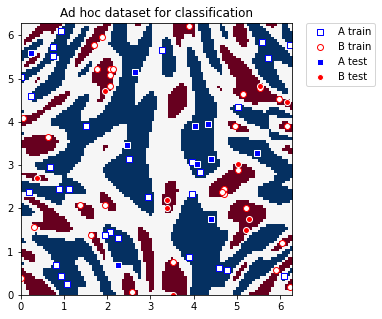

In [ ]:
plot_data(train_features, train_labels, test_features, test_labels, total)

In [ ]:
# instantiate the quantum simulator
backend = QuantumInstance(BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed) 

# performing the QSVM with different feature maps and different parameters 
print("Performance on ZZFeatureMap with different number of reps")
print()
for i in range(2,5):
    feature_map = ZZFeatureMap(feature_dimension=dimension, reps=i, entanglement="linear")
    kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
    qsvc = QSVC(quantum_kernel=kernel)
    qsvc.fit(train_features, train_labels)
    qsvc_score = qsvc.score(test_features, test_labels)
    print(f"QSVC classification test score: {qsvc_score} using {i} reps")
    
print()
print()
print("Performance on ZFeatureMap with different number of reps")
print()
for i in range(2,5):
    feature_map = ZFeatureMap(feature_dimension=dimension, reps=i)
    kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
    qsvc = QSVC(quantum_kernel=kernel)
    qsvc.fit(train_features, train_labels)
    qsvc_score = qsvc.score(test_features, test_labels)
    print(f"QSVC classification test score: {qsvc_score} using {i} reps")


Performance on ZZFeatureMap with different number of reps

QSVC classification test score: 1.0 using 2 reps
QSVC classification test score: 0.85 using 3 reps
QSVC classification test score: 0.65 using 4 reps


Performance on ZFeatureMap with different number of reps

QSVC classification test score: 0.85 using 2 reps
QSVC classification test score: 0.6 using 3 reps
QSVC classification test score: 0.75 using 4 reps


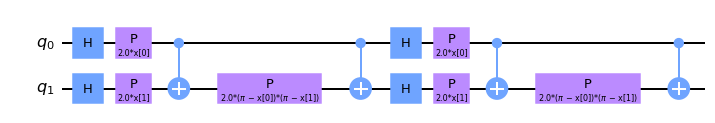

In [ ]:
# plot of the circuit that performs better, ZZFeatureMap with 2 reps and linear entanglement
prep = ZZFeatureMap(2, reps=2, entanglement="linear").decompose()
prep.draw("mpl")

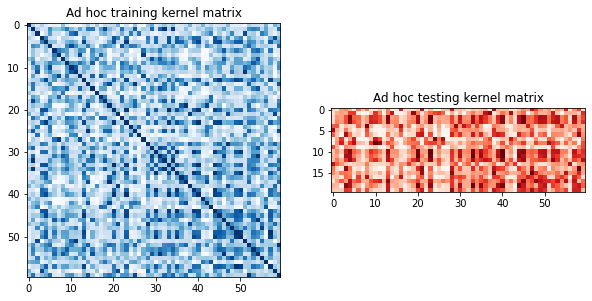

In [ ]:
# build the kernel matrices either for the training set either for the test set
matrix_train = kernel.evaluate(x_vec=train_features)
matrix_test = kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues")
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()